In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
EPOCHS = 100
BATCH_SIZE = 1000
REPETITIONS = 5

In [30]:
inc_decomp_file = np.load("/gluster/home/ofrebato/baler/workspaces/MNIST/MNIST_project/output/decompressed_output/decompressed_with_outliers.npz")
sep_decomp_file = np.load("/gluster/home/ofrebato/baler/workspaces/MNIST/MNIST_project/output/decompressed_output/decompressed.npz")
sep_orig_file = np.load("/gluster/home/ofrebato/baler/workspaces/MNIST/data/non_outliers.npz")
inc_orig_file = np.load("/gluster/home/ofrebato/baler/workspaces/MNIST/data/outlier_order.npz")
print(sep_decomp_file["data"].shape)
print(inc_decomp_file["data"].shape)
print(sep_orig_file["data"].shape)
print(inc_orig_file["data"].shape)
print(np.all(sep_orig_file["data"] == inc_orig_file["data"][:sep_orig_file["data"].shape[0]]))

(70000, 28, 28)
(70000, 28, 28)
(69305, 28, 28)
(70000, 28, 28)
True


In [31]:
sep_diffs = np.array([np.sum((image_decomp - image_orig)**2) for image_decomp, image_orig in zip(sep_decomp_file["data"].astype(np.float32), sep_orig_file["data"].astype(np.float32))])
inc_diffs = np.array([np.sum((image_decomp - image_orig)**2) for image_decomp, image_orig in zip(inc_decomp_file["data"].astype(np.float32), inc_orig_file["data"].astype(np.float32))])[:len(sep_diffs)]

In [32]:
digit_idxs = {}
for digit in range(10):
    digit_idxs[digit] = np.where(sep_orig_file["names"] == digit)[0]


Text(0.5, 0.98, 'Effect of separating outliers before training for every digit. ')

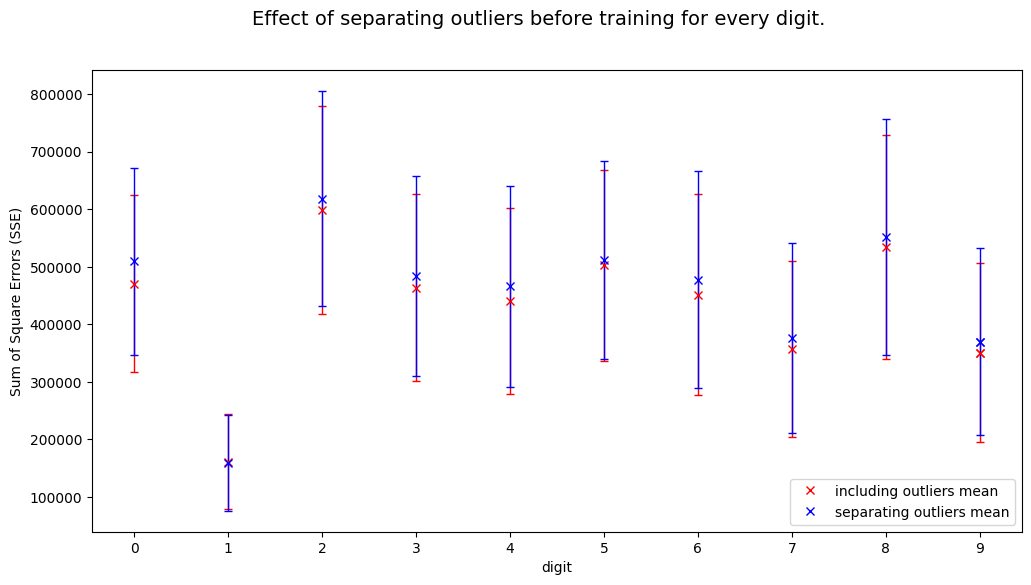

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
for digit in digit_idxs.keys():
    inc_mean = np.mean(inc_diffs[digit_idxs[digit]])
    inc_std = np.std(inc_diffs[digit_idxs[digit]])
    sep_mean = np.mean(sep_diffs[digit_idxs[digit]])
    sep_std = np.std(sep_diffs[digit_idxs[digit]])
    digit=str(digit)
    ax.errorbar(digit, inc_mean, yerr=inc_std, fmt="rx", elinewidth=1, capsize=3)
    ax.errorbar(digit, sep_mean, yerr=sep_std, fmt="bx", elinewidth=1, capsize=3)

ax.errorbar(digit, inc_mean, fmt="rx", label="including outliers mean")
ax.errorbar(digit, sep_mean, fmt="bx", label="separating outliers mean")
ax.set_xlabel("digit")
ax.set_ylabel("Sum of Square Errors (SSE)")
ax.legend()

fig.suptitle(f"Effect of separating outliers before training for every digit. ", fontsize=14)
# plt.savefig("run_multiple_10_reps.png", dpi=600)

In [34]:
all_results = np.load("/gluster/home/ofrebato/baler/run_multiple_results/results.npz", allow_pickle=True)
including = {key: all_results['including'][()][key] for key in all_results['including'][()]}
separated = {key: all_results['separate'][()][key] for key in all_results['separate'][()]}


Text(0.5, 0.98, 'Effect of separating and keeping outliers for every digit. Epochs=100, batch_size=1000, repetitions=5')

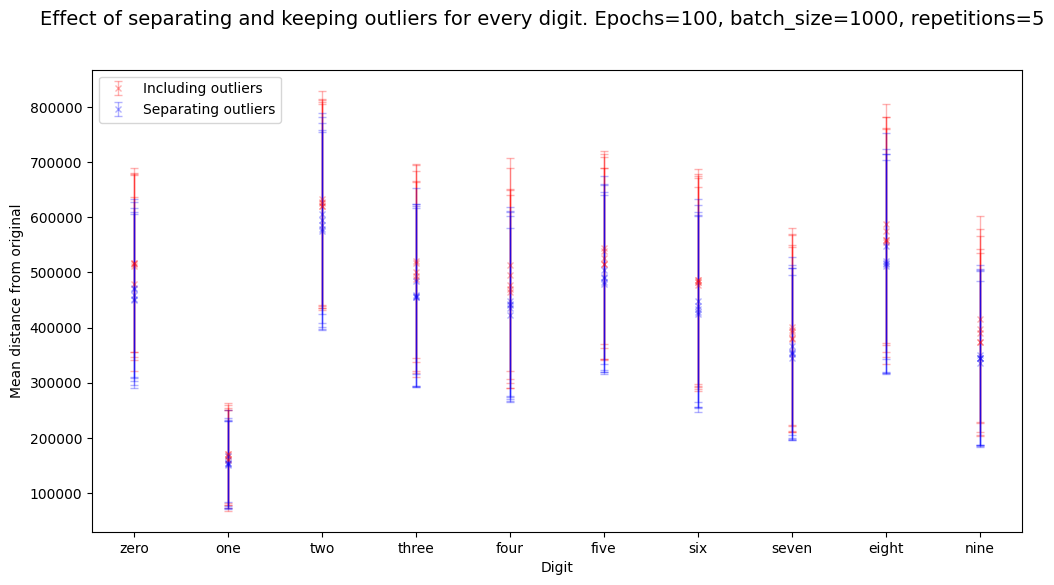

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
start = True
for key in including.keys():
    if start:
        ax.errorbar([key]*len(including[key]), including[key][:,0], yerr=including[key][:,1], fmt="xr", markersize=5, capsize=3, elinewidth=1, alpha=0.3, label="Including outliers")
        ax.errorbar([key]*len(separated[key]), separated[key][:,0], yerr=separated[key][:,1], fmt="xb", markersize=5, capsize=3, elinewidth=1, alpha=0.3, label="Separating outliers")
        start = False
    else:
        ax.errorbar([key]*len(including[key]), including[key][:,0], yerr=including[key][:,1], fmt="xr", markersize=5, capsize=3, elinewidth=1, alpha=0.3)
        ax.errorbar([key]*len(separated[key]), separated[key][:,0], yerr=separated[key][:,1], fmt="xb", markersize=5, capsize=3, elinewidth=1, alpha=0.3)
ax.set_xlabel("Digit")
ax.set_ylabel("Mean distance from original")
ax.legend()
fig.suptitle(f"Effect of separating and keeping outliers for every digit. Epochs={EPOCHS}, batch_size={BATCH_SIZE}, repetitions={REPETITIONS}", fontsize=14)



Mean percentage difference: 8.534%


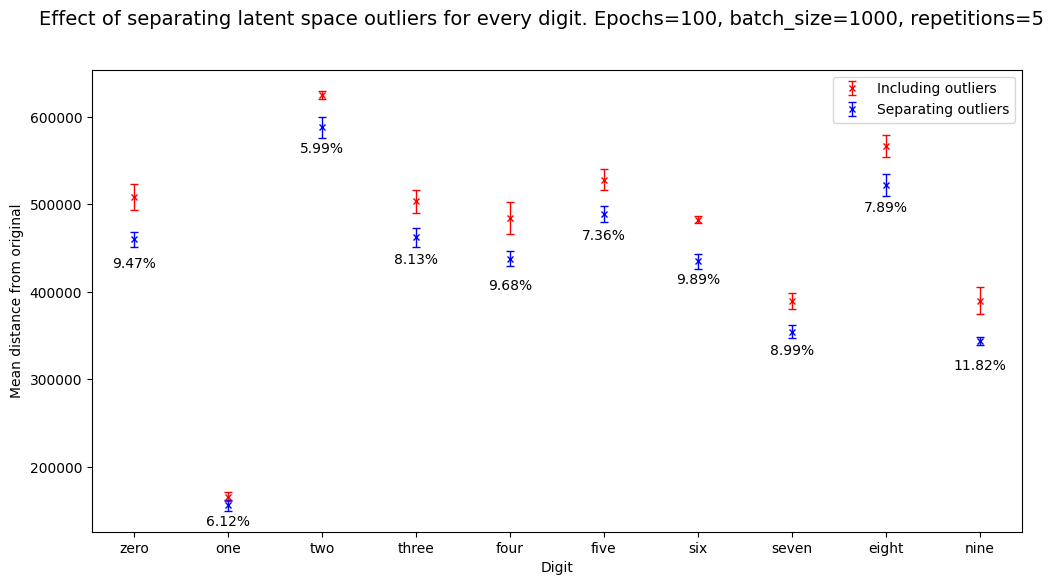

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))
start = True
perc_diffs = []
for key in including.keys():
    mean_including = np.mean(including[key][:,0])
    std_including = np.std(including[key][:,0])
    mean_separated = np.mean(separated[key][:,0])
    std_separated = np.std(separated[key][:,0])
    if start:
        ax.errorbar(key, mean_including, yerr=std_including, fmt="xr", markersize=5, capsize=3, elinewidth=1, label="Including outliers")
        ax.errorbar(key, mean_separated, yerr=std_separated, fmt="xb", markersize=5, capsize=3, elinewidth=1, label="Separating outliers")
        start = False
    else:
        ax.errorbar(key, np.mean(including[key][:,0]), yerr=np.std(including[key][:,0]), fmt="xr", markersize=5, capsize=3, elinewidth=1)
        ax.errorbar(key, np.mean(separated[key][:,0]), yerr=np.std(separated[key][:,0]), fmt="xb", markersize=5, capsize=3, elinewidth=1)
    perc_diff = (mean_including - mean_separated) * 100 / mean_including
    perc_diffs.append(perc_diff)
    y_pos = min([mean_including, mean_separated]) - max([std_including, std_separated]) - 5000
    ax.text(key, y_pos, f"{perc_diff:.2f}%", ha="center", va="top")
ax.set_xlabel("Digit")
ax.set_ylabel("Mean distance from original")
ax.legend()
fig.suptitle(f"Effect of separating latent space outliers for every digit. Epochs={EPOCHS}, batch_size={BATCH_SIZE}, repetitions={REPETITIONS}", fontsize=14)
plt.savefig("latent_outlier_mean_error_by_digit.png", dpi=600)
print(f"Mean percentage difference: {np.mean(perc_diffs):.3f}%")
